# Clone my driving behavior

In [38]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Lambda, Dropout, Cropping2D, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

import cloning.image_generator as ig
from cloning.visualizations import plot_layers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
user = !whoami
user = user[0]

In [40]:
PROJECT_DIR = '/home/ubuntu/cloning' if user == 'ubuntu' else '/home/mariosk/Desktop/autonomous_driving/CarND-Behavioral-Cloning-P3'
IMAGE_SHAPE = (160, 320, 3)

## Load images and measurements

In [41]:
def load_images_and_measurements(image_set_directory):
    driving_log = (
        pd.read_csv(
            f'./my-videos-center/{image_set_directory}/driving_log.csv', 
            header=None,
            names=[
                'center_image', 'left_image', 'right_image', 
                'steering_angle', 'throttle', 'break', 'speed'])
        .assign(
            center_image=lambda df: 
                PROJECT_DIR 
                + f'/my-videos-center/{image_set_directory}/IMG/' 
                + df['center_image'].str.split('IMG').str[1]))
    
    images = np.stack(driving_log['center_image'].map(plt.imread), axis=0)
    measurements = driving_log['steering_angle']
    
    return images, measurements

In [42]:
def load_image_sets(image_set_names, smoothen=1):
    image_sets, measure_sets = zip(*[load_images_and_measurements(name, smoothen) for name in image_set_names])
    
    return np.vstack(image_sets), np.hstack(measure_sets)

In [43]:
%%time
train_images, train_meas = load_image_sets([
    'first_drives', 
    '3_forward_rounds', 
    '3_backward_rounds',
    'edges_forward',
    'edges_backward',
    'edges_smooth',
    '2_rounds_for_testing',
    '3_more_fw_rounds',
    '3_more_bw_rounds',
#     'driving_on_the_edge_fw_left',
#     'driving_on_the_edge_fw_right',
#     '6_fw',
#     '6_bw',
#     '3_bw_hard',
#     '3_fw_hard',
#     '1_round_fw_hard_level'
], smoothen=SMOOTHENING)

print(f'Number of train samples: {train_meas.shape[0]}')

Number of train samples: 61860
CPU times: user 1min 13s, sys: 5.74 s, total: 1min 19s
Wall time: 1min 19s


In [44]:
%%time
valid_images, valid_meas = load_image_sets(["validation_rounds", "validation_rounds_bw"], smoothen=SMOOTHENING)
print(f'Number of valid samples: {valid_meas.shape[0]}')

Number of valid samples: 4234
CPU times: user 5.14 s, sys: 400 ms, total: 5.54 s
Wall time: 5.53 s


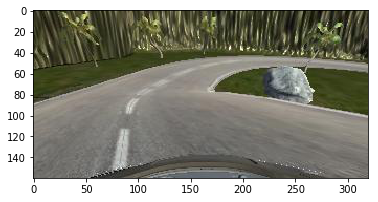

In [45]:
plt.imshow(next(ig.image_generator_from_dataset(train_images, train_meas, augment=True))[0][0])
plt.show()

In [46]:
model = Sequential([
    Cropping2D(cropping=((70, 25), (0, 0)), input_shape=IMAGE_SHAPE, name='crop'),
    Lambda(lambda image: image / 255.0 - 0.5, name='scale'),
    
    Conv2D(24, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(36, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(48, (5, 5), strides=(2, 2)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    
    Dense(100),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(50),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(10),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(1, activation='linear')
])

model.compile(loss='mse', optimizer=Adam(lr=0.0005))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
crop (Lambda)                (None, 80, 320, 3)        0         
_________________________________________________________________
resize (Lambda)              (None, 320, 320, 3)       0         
_________________________________________________________________
scale (Lambda)               (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 158, 158, 24)      1824      
_________________________________________________________________
batch_normalization_10 (Batc (None, 158, 158, 24)      96        
_________________________________________________________________
activation_10 (Activation)   (None, 158, 158, 24)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 77, 77, 36)        21636     
__________

## Train model

In [48]:
batch_size = 128

train_generator = ig.image_generator_from_dataset(train_images, train_meas, augment=True, batch_size=batch_size)
valid_generator = ig.image_generator_from_dataset(valid_images, valid_meas, batch_size=batch_size)

In [49]:
%%time
steps_per_epoch = int(train_meas.shape[0] / batch_size)
validation_steps = int(valid_meas.shape[0] / batch_size)

model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=1,
    steps_per_epoch=steps_per_epoch,
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

Epoch 1/1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


483/483 [==============================] - 68s 140ms/step - loss: 0.3837 - val_loss: 0.0078
CPU times: user 51.9 s, sys: 30.7 s, total: 1min 22s
Wall time: 1min 9s


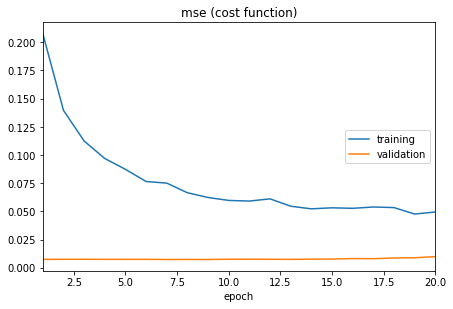

mse (cost function):
training   (min:    0.048, max:    0.207, cur:    0.049)
validation (min:    0.007, max:    0.010, cur:    0.010)
CPU times: user 15min 31s, sys: 10min 12s, total: 25min 44s
Wall time: 21min 26s


In [50]:
%%time
model.fit_generator(
    train_generator,
    validation_data=[valid_images, valid_meas],
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[PlotLossesKeras()],
    max_queue_size=40,
    use_multiprocessing=True,
    workers=8
)

In [51]:
validation_rmse = np.sqrt(model.evaluate(valid_images, valid_meas))

4234/4234 [==============================] - 2s 430us/step


In [52]:
model.save('./models/model_nvidia_double_edge_careful.h5a')

In [53]:
!./upload_models_to_s3.sh

upload: models/model_nvidia_double_edge_careful.h5a to s3://behavioral-cloning-models/model_nvidia_double_edge_careful.h5a


## Compare original and predicted angle distributions

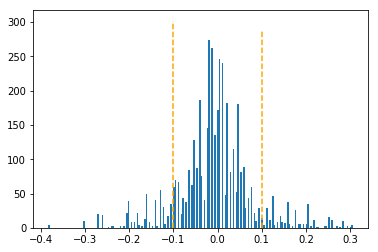

In [54]:
plt.hist(valid_meas, bins=200)
plt.vlines(validation_rmse, *plt.ylim(), color='orange', linestyle='--')
plt.vlines(-validation_rmse, *plt.ylim(), color='orange', linestyle='--')
plt.show()

In [55]:
%%time
predictions = model.predict(valid_images)

CPU times: user 2.04 s, sys: 76 ms, total: 2.12 s
Wall time: 2.2 s


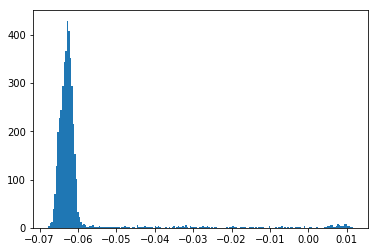

In [56]:
plt.hist(predictions, bins=200)
plt.show()

## Visualize output of convolution layers

In [57]:
inp = model.input
relevant_layers = [layer for layer in model.layers if 'conv2d' in layer.name]
layer_names = [layer.name for layer in relevant_layers]
outputs = [layer.output for layer in relevant_layers]
evaluation_functions = K.function([inp, K.learning_phase()], outputs)

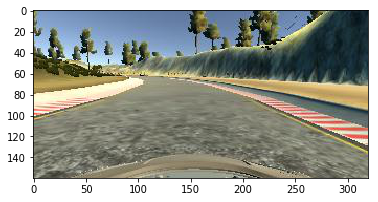

In [58]:
test_image = valid_images[0]
plt.imshow(test_image)
plt.show()

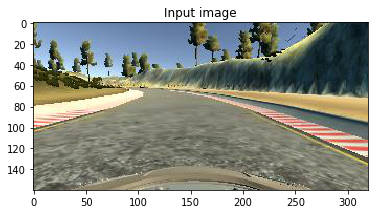

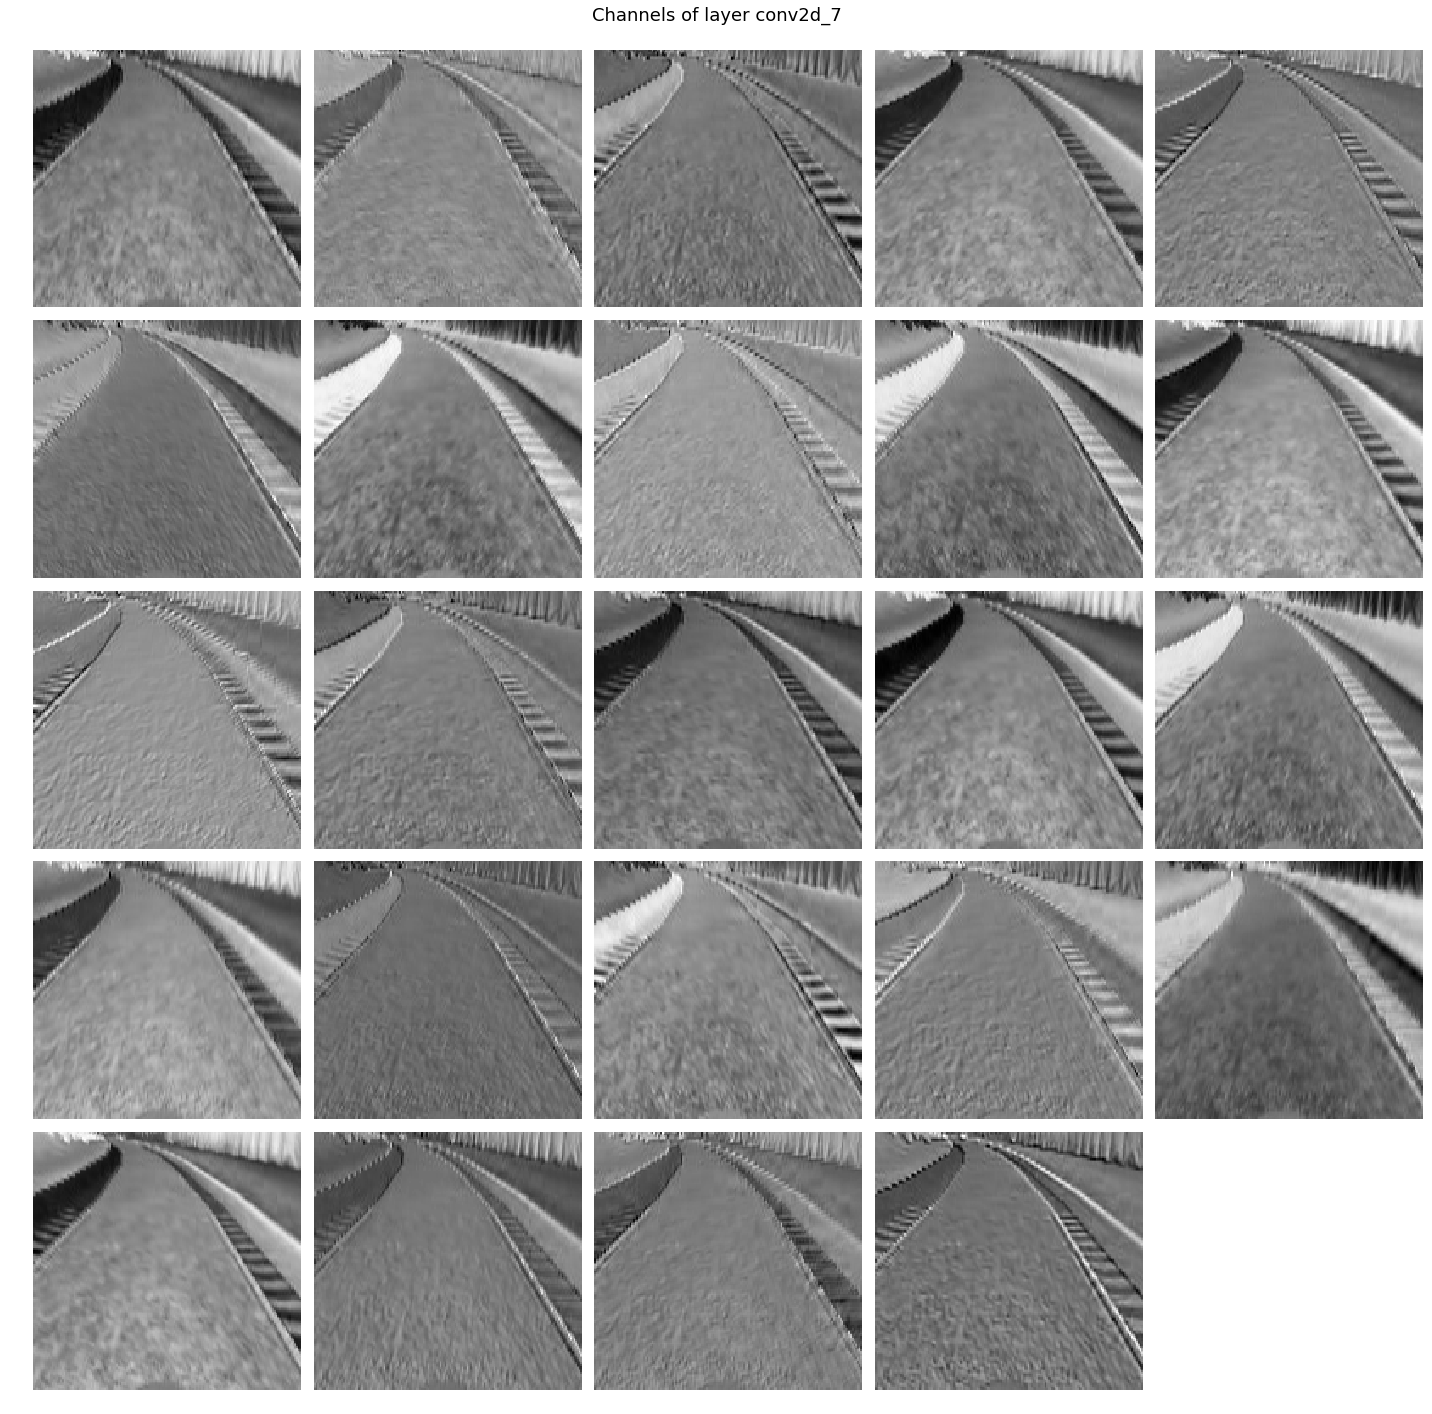

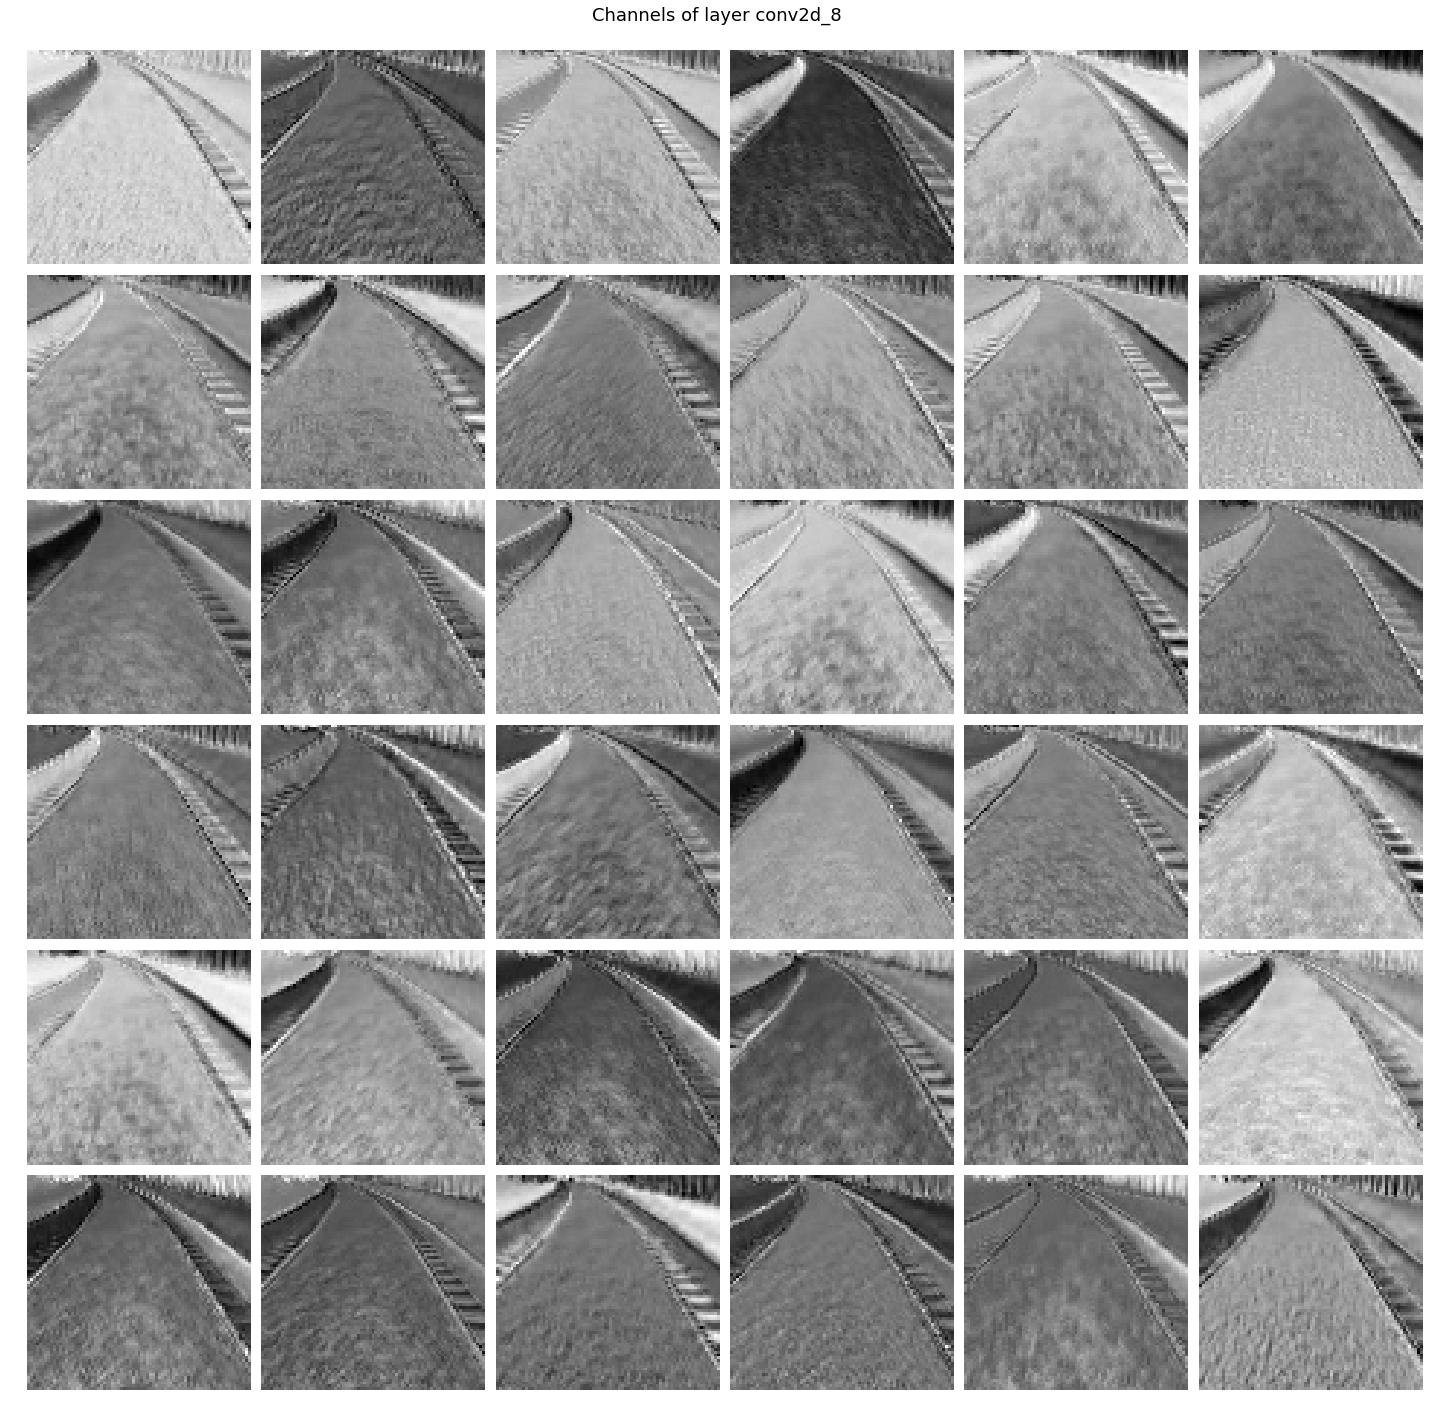

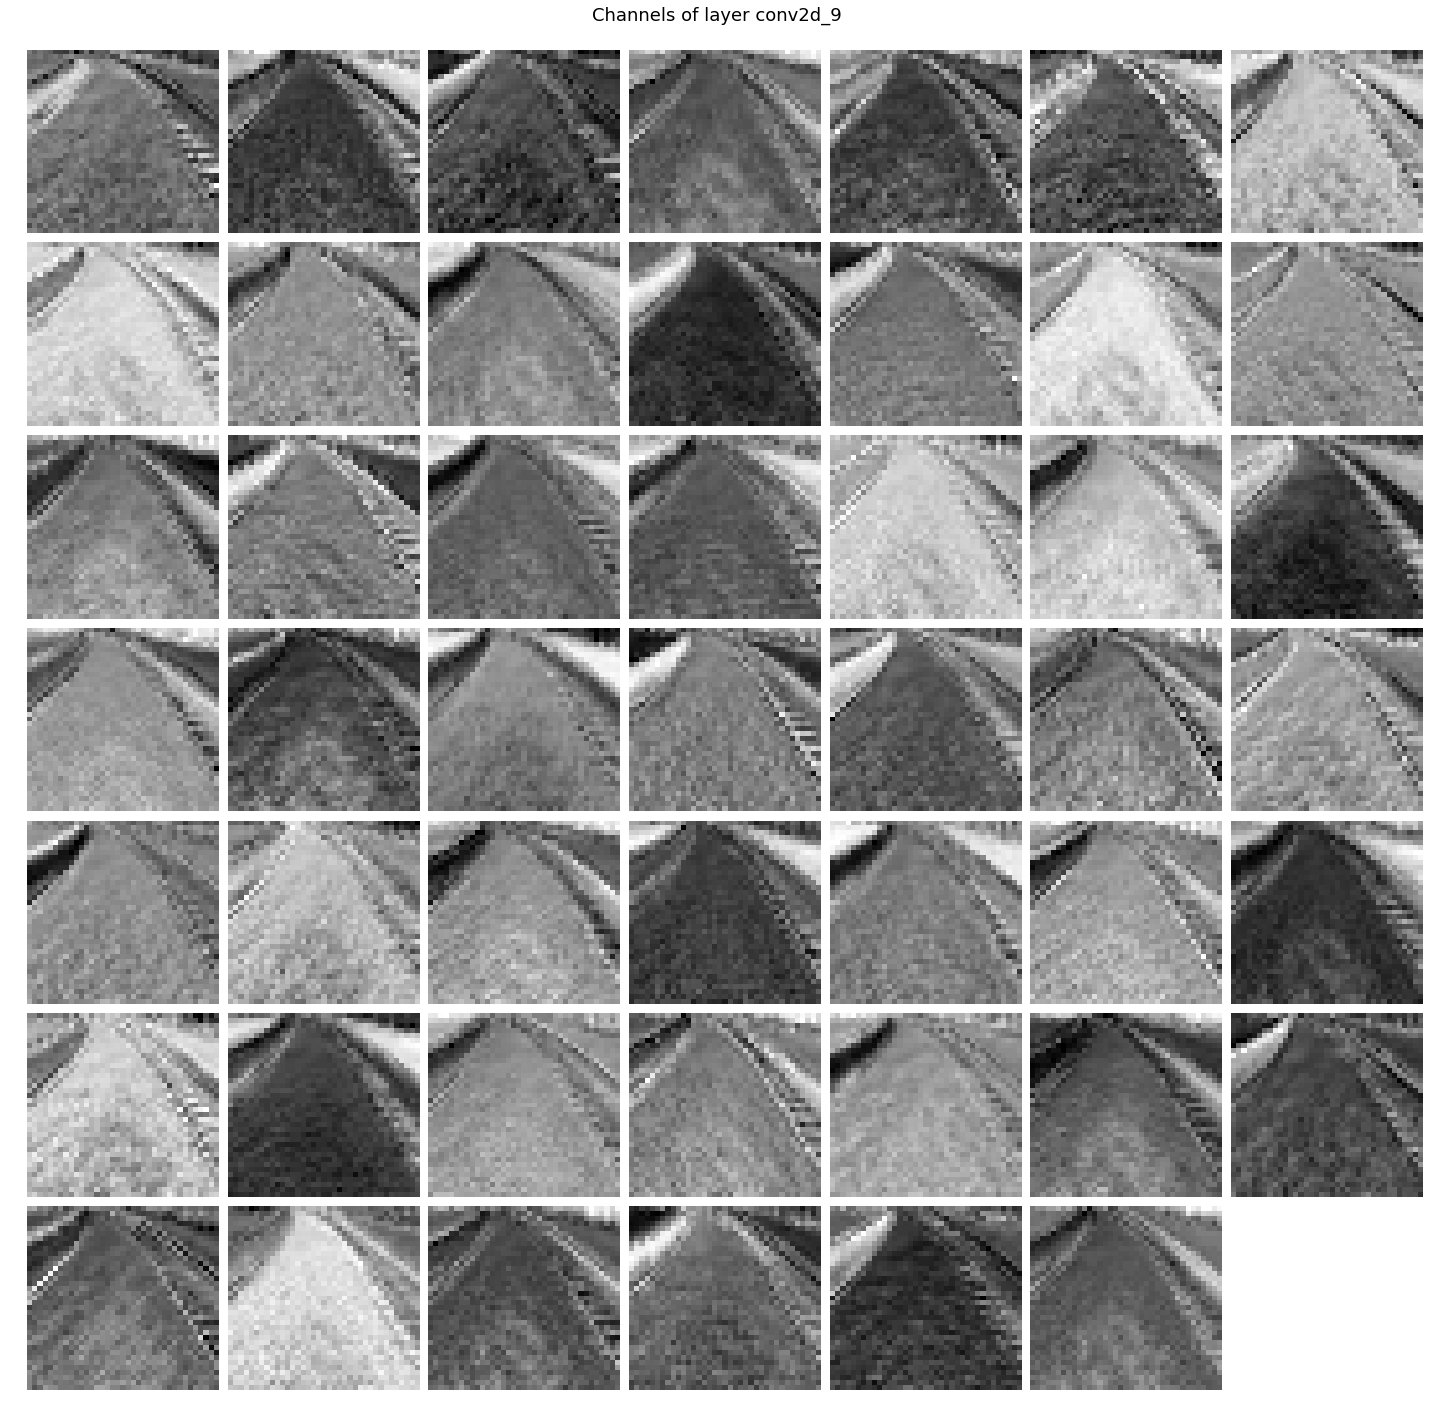

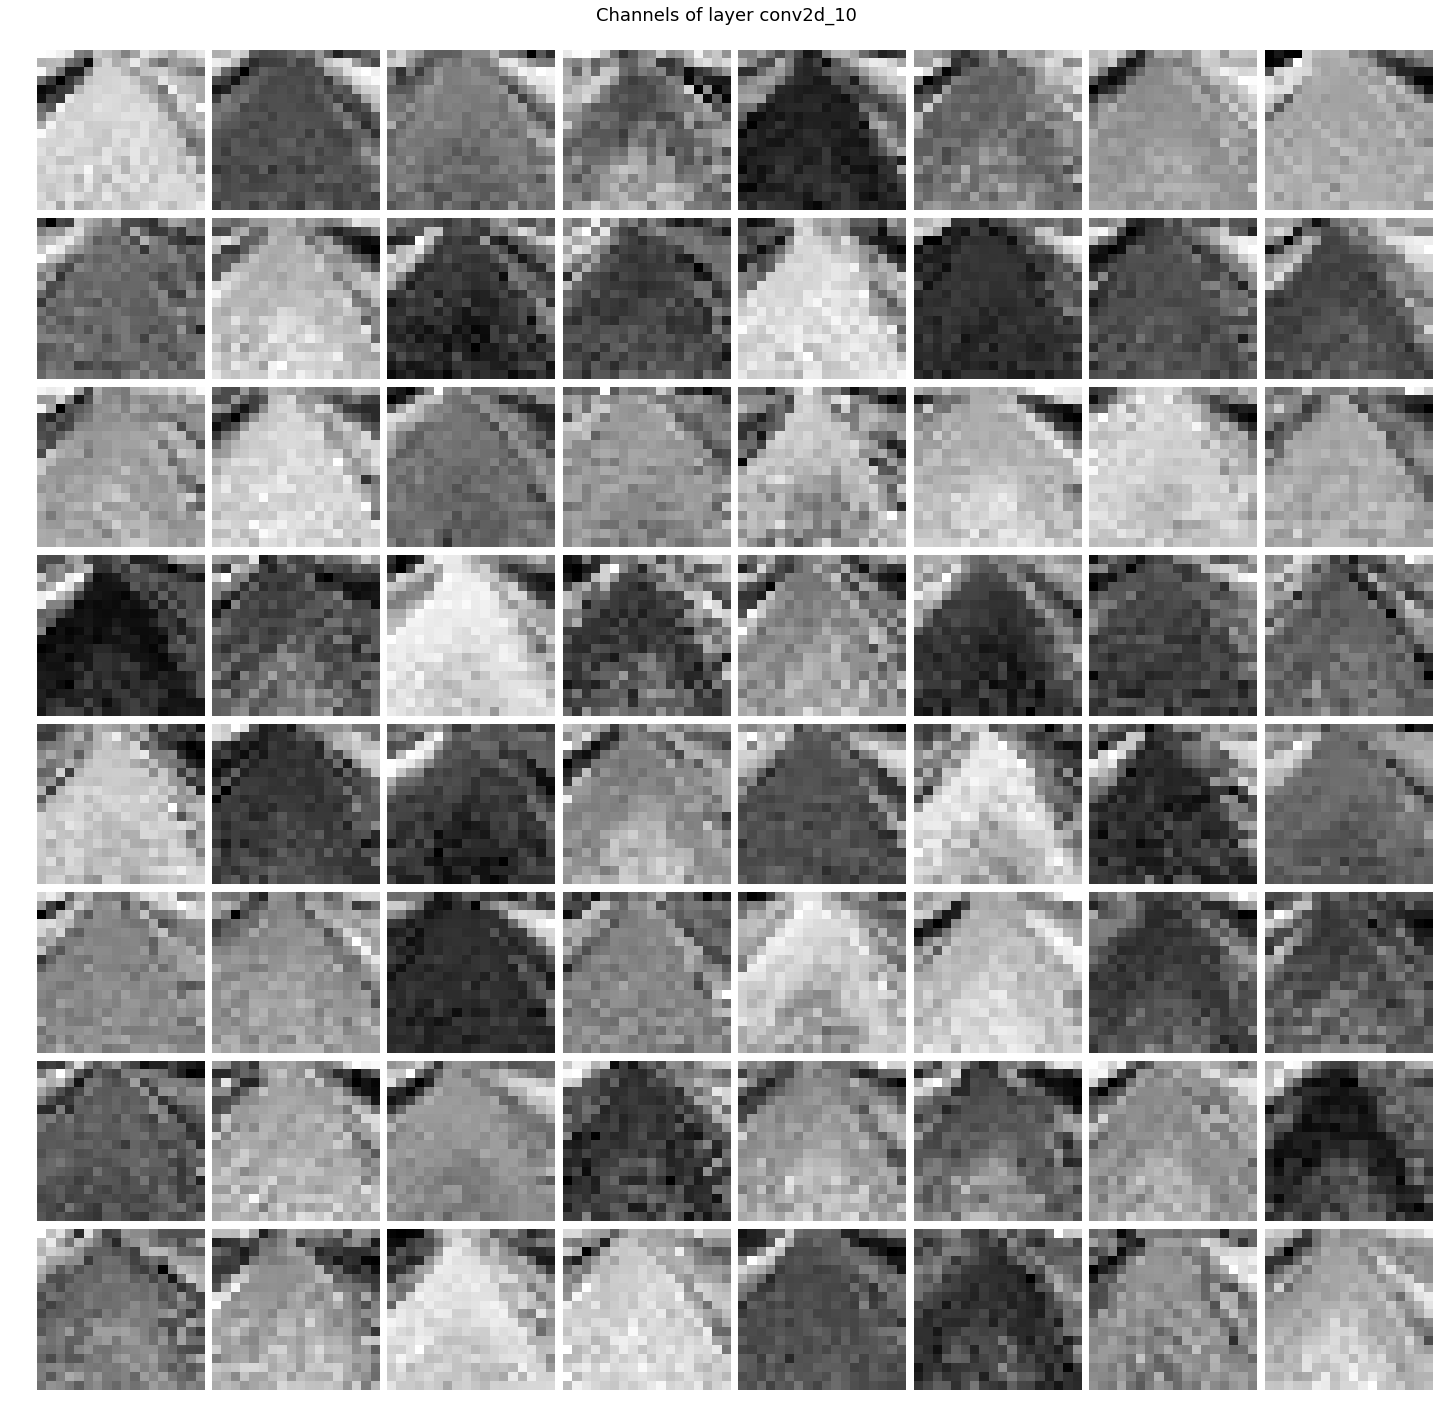

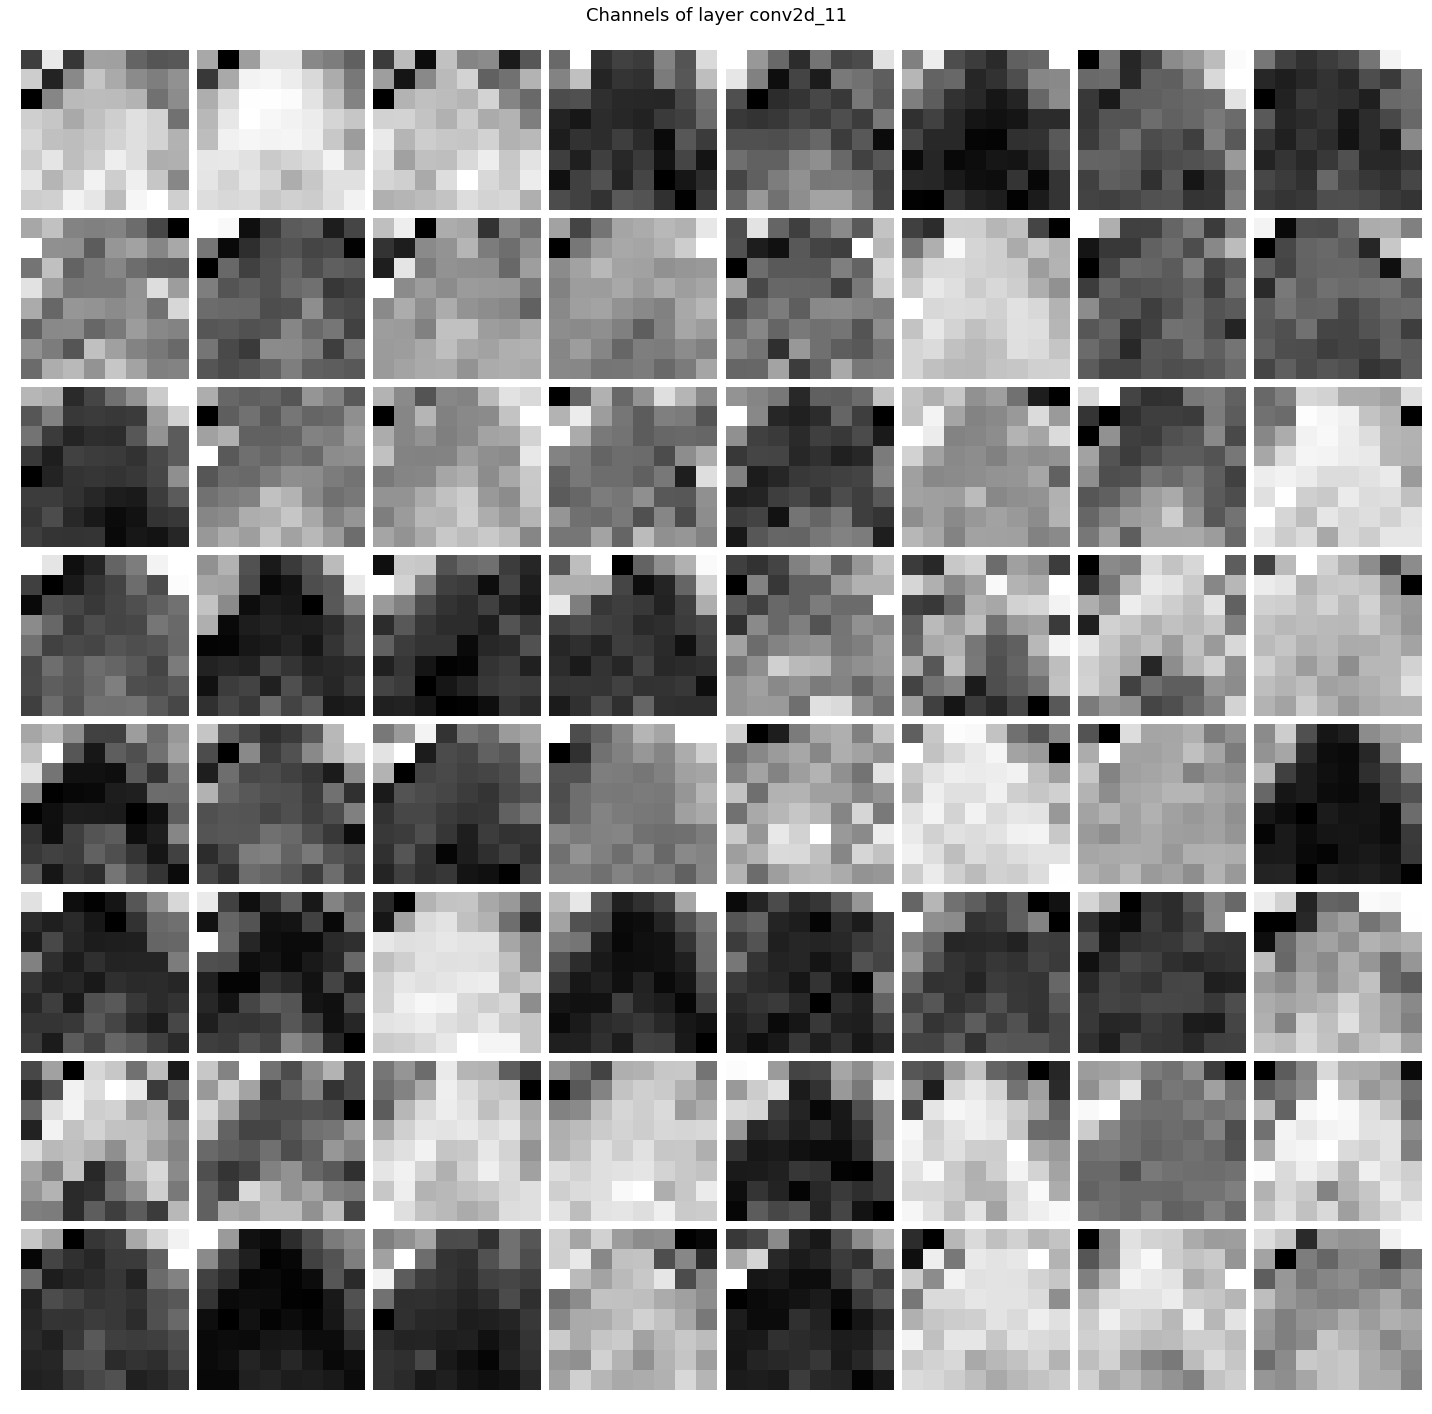

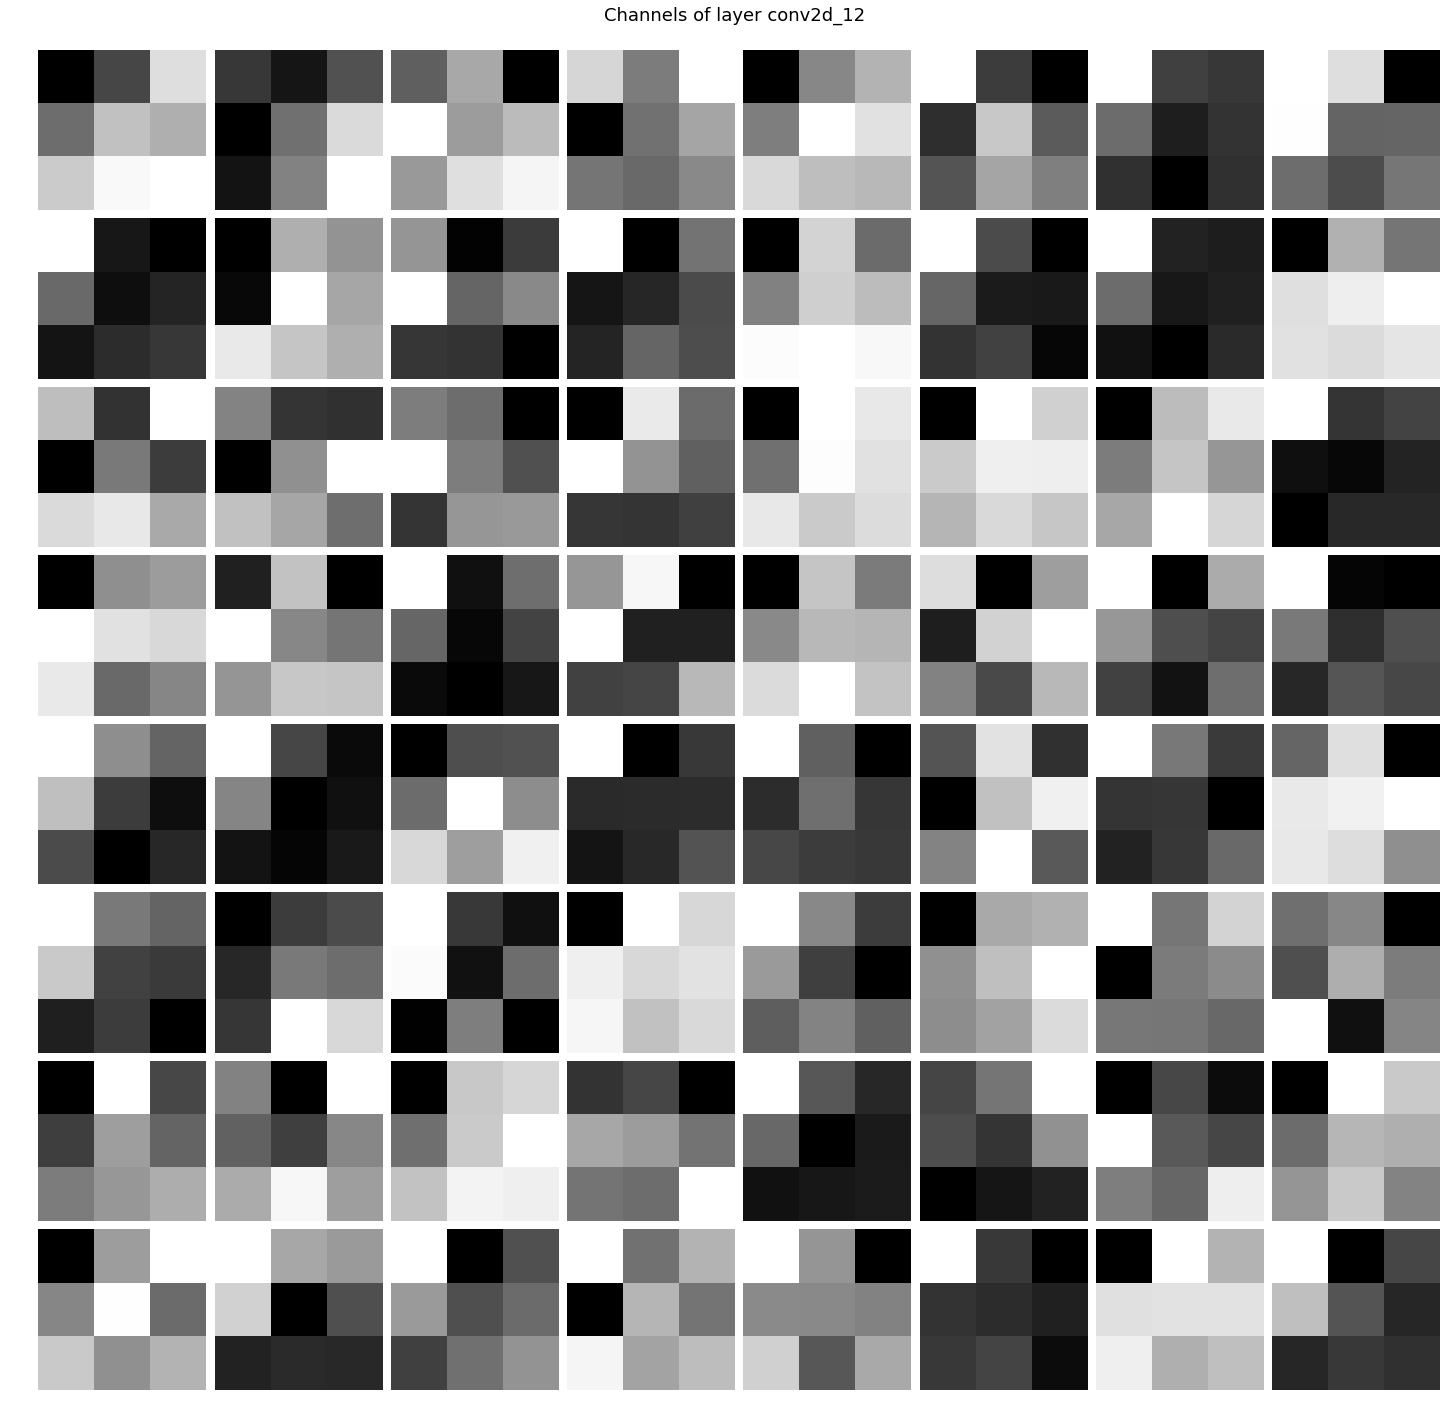

In [59]:
plot_layers(test_image, evaluation_functions, layer_names)